In [3]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from sklearn import preprocessing
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn

from IPython.display import clear_output
import pickle
import os
import sys

import scanpy as sc
import scanpy.external as sce
import bbknn

from numpy import ones,vstack
from numpy.linalg import lstsq

root = '/mnt/G' if 'mnt' in os.getcwd() else 'G:'

def plot_basal_suprabasal_cutoff_v2(ax, x0 = -2.5, x1 = 1, m = -1.09807084, c = 5.8597005, ls = '--', color = 'dimgrey', lw = 2): 
    ax.plot([x0,x1], [m*x0+c, m*x1+c], ls = ls, c = color, lw = lw)

In [4]:
path_skin_scripts = '{}/My Drive/Python/Projects'.format(root)
sys.path.append(path_skin_scripts)
from Skin_scripts import *

In [5]:
filename = 'NCB_2022_final_integrated_dataset'
path = '/mnt/g/My Drive/MKA/Papers/Greco/Katie/2022_NCB_Final/Data upload'
adata= sc.read_h5ad(os.path.join(path, f'{filename}.h5ad'))
adata.raw = sc.read_csv(os.path.join(path, f'{filename}_downscaled_raw_counts.csv'))

b_sb_cutoff = 0.8725141776937618
adata.obs['binned_delamination'] = pd.Categorical(adata.obs['binned_delamination'])

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


In [6]:
aragona_path = '{}/Users/karlan/Google Drive/MKA/Papers/Greco/Katie/Aragona'.format(root)
aragona_data = sc.read_csv(os.path.join(aragona_path, 'Aragona_RawData.csv'))

In [7]:
metadata = pd.read_csv(os.path.join(aragona_path, 'Aragona_MetaData.csv'), index_col = 0)
umap = pd.read_csv(os.path.join(aragona_path, 'Aragona_UMAP_coordinates.csv'), index_col = 0)

In [8]:
aragona_data = aragona_data.T.copy()

In [9]:
aragona_data.obs = metadata

In [10]:
aragona_data.obsm['X_umap'] = umap.values

In [11]:
aragona_data

AnnData object with n_obs × n_vars = 4659 × 10237
    obs: 'nGene', 'nUMI', 'Barcode', 'Sample', 'Condition', 'Batch', 'use', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features_by_counts_endogenous', 'log10_total_features_by_counts_endogenous', 'total_counts_endogenous', 'log10_total_counts_endogenous', 'pct_counts_endogenous', 'pct_counts_in_top_50_features_endogenous', 'pct_counts_in_top_100_features_endogenous', 'pct_counts_in_top_200_features_endogenous', 'pct_counts_in_top_500_features_endogenous', 'total_features_by_counts_feature_control', 'log10_total_features_by_counts_feature_control', 'total_counts_feature_control', 'log10_total_counts_feature_control', 'pct_counts_feature_control', 'pct_counts_in_top_50_features_feature_control', 'pct_counts_in_top_100_featur

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Sample' as categorical
... storing 'Condition' as categorical
... storing 'cc_phase' as categorical
... storing 'orig.ident' as categorical
... storing 'cell_type' as categorical
... storing 'sub_cell_type' as categorical


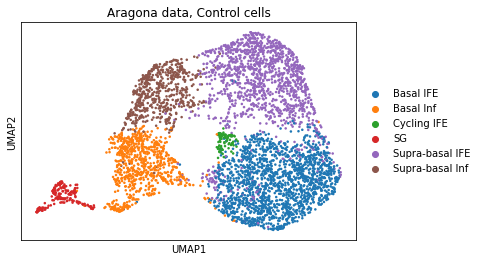

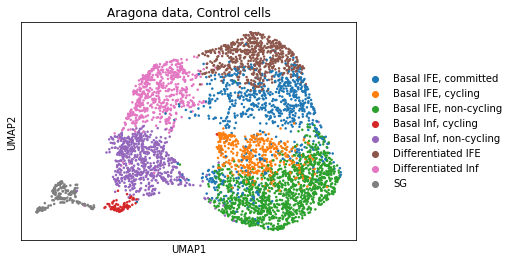

In [12]:
sc.pl.umap(aragona_data, color = 'cell_type', title='Aragona data, Control cells')
sc.pl.umap(aragona_data, color = 'sub_cell_type', title='Aragona data, Control cells')

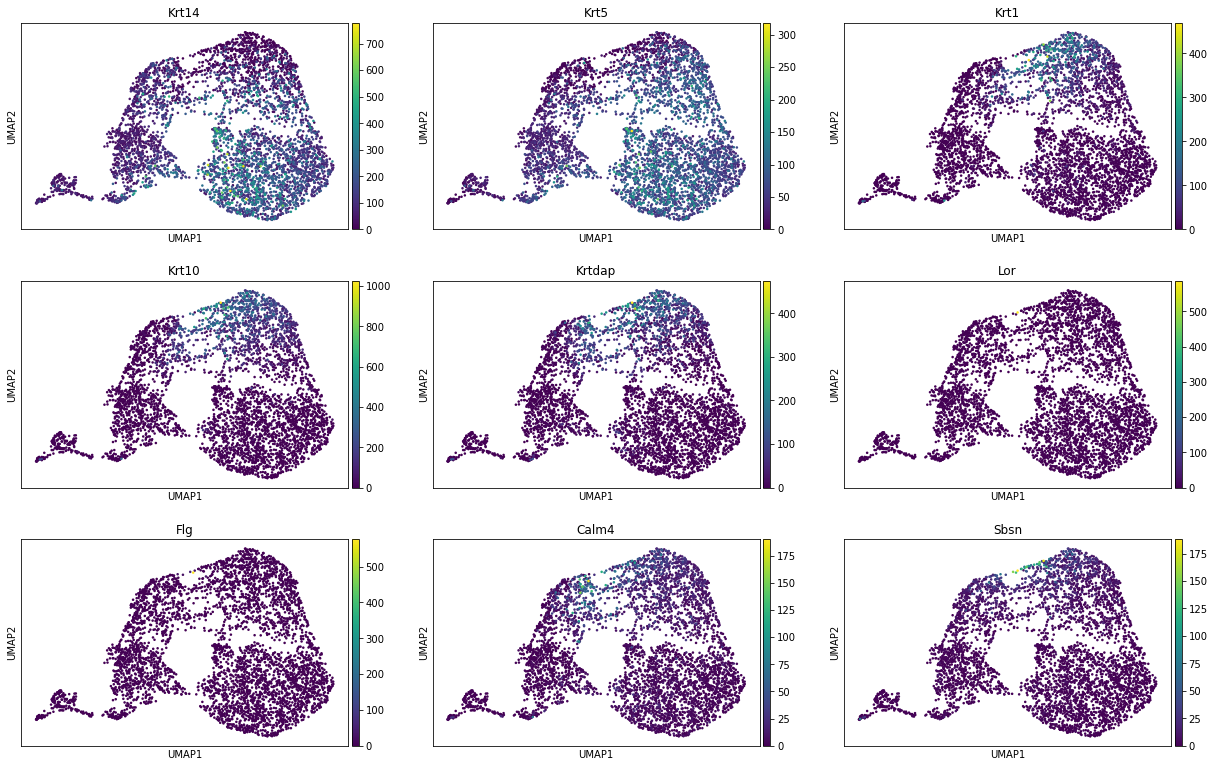

In [13]:
genes = ['Krt14','Krt5','Krt1','Krt10','Krtdap','Lor','Flg','Calm4','Sbsn']
sc.pl.umap(aragona_data, color = genes, ncols = 3)

In [14]:
sc.pp.filter_cells(aragona_data, min_counts=100)

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:
df = pd.DataFrame(data = np.sum(adata.X, axis = 1), index = adata.obs_names, columns = ['total_counts'])
df['batch'] = adata.obs['batch']

<AxesSubplot:ylabel='total_counts'>

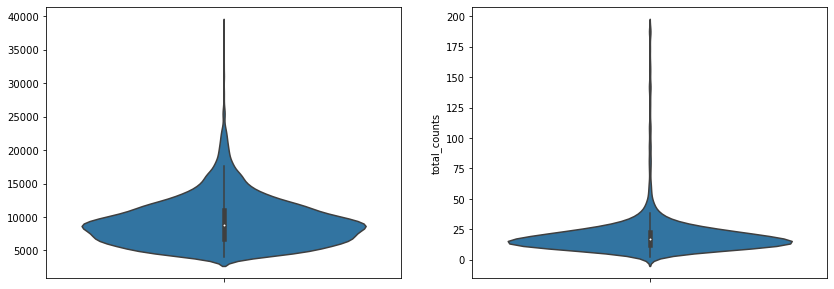

In [16]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))
sbn.violinplot(y = np.sum(aragona_data.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(data = df, y = 'total_counts', orient='v', ax = axes[1], hue = 'batch')

In [17]:
aragona_ife = aragona_data[aragona_data.obs['cell_type'].isin(['Basal IFE', 'Cycling_IFE', 'Supra-basal IFE'])].copy()

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


<AxesSubplot:ylabel='total_counts'>

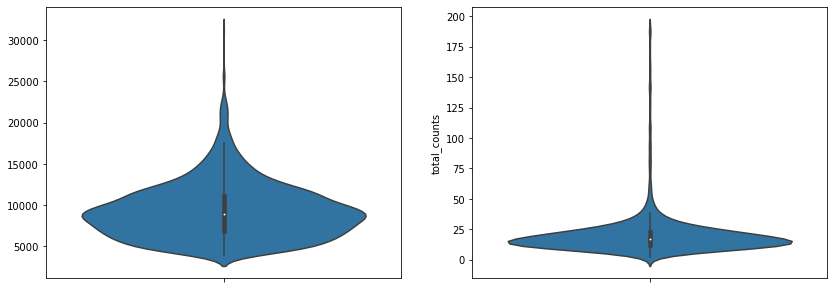

In [18]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))
sbn.violinplot(y = np.sum(aragona_ife.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(data = df, y = 'total_counts', orient='v', ax = axes[1], hue = 'batch')

In [19]:
aragona_ife_ds = sc.pp.downsample_counts(aragona_ife, counts_per_cell=2000, copy = True)

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:ylabel='total_counts'>

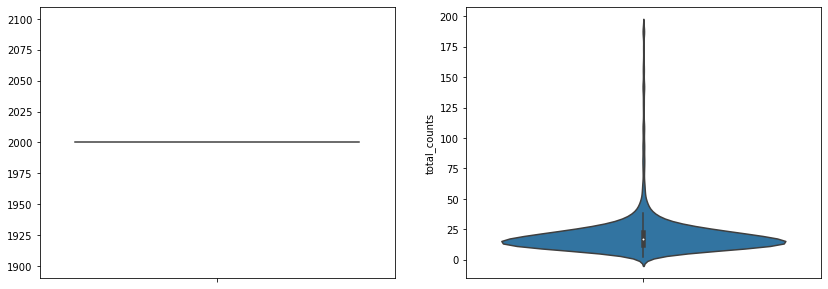

In [20]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))
sbn.violinplot(y = np.sum(aragona_ife_ds.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(data = df, y = 'total_counts', orient='v', ax = axes[1], hue = 'batch')

In [21]:
sc.pp.normalize_total(aragona_ife_ds)
sc.pp.log1p(aragona_ife_ds)

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
sc.pp.normalize_total(aragona_ife)
sc.pp.log1p(aragona_ife)

<AxesSubplot:ylabel='total_counts'>

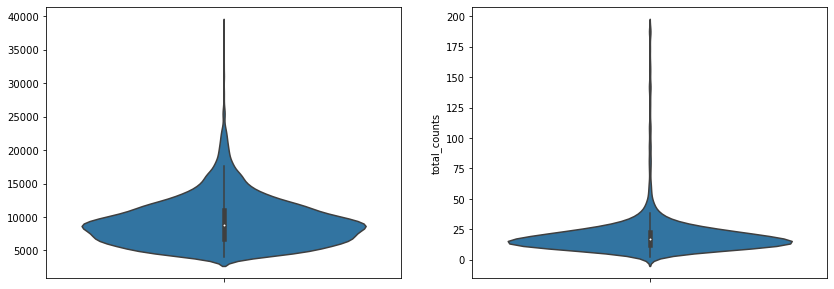

In [23]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))
sbn.violinplot(y = np.sum(aragona_data.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(data = df, y = 'total_counts', orient='v', ax = axes[1], hue = 'batch')

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:ylabel='total_counts'>

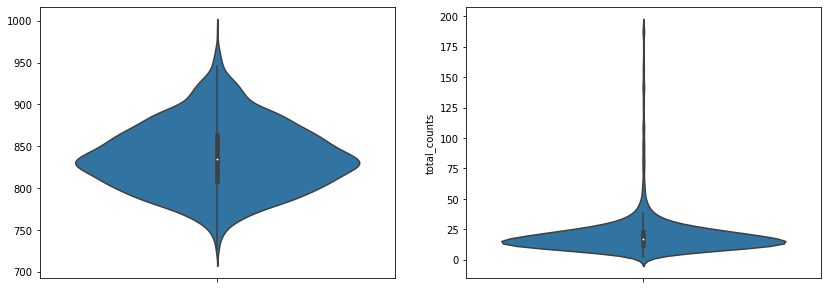

In [24]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))
sbn.violinplot(y = np.sum(aragona_ife_ds.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(data = df, y = 'total_counts', orient='v', ax = axes[1], hue = 'batch')

In [52]:
#Save log-normalized data
pd.DataFrame(data = aragona_ife.X, index = aragona_ife_ds.obs_names, columns = aragona_ife_ds.var_names).to_csv(
os.path.join(aragona_path, '20201006_Aragona_IFE_log_normalized_filtered_counts.csv'))

In [26]:
shared_genes = adata.var_names.intersection(aragona_ife.var_names)

In [27]:
aragona_ife_subset = aragona_ife[:, shared_genes].copy()
adata_subset = adata[:, shared_genes].copy()

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:ylabel='total_counts'>

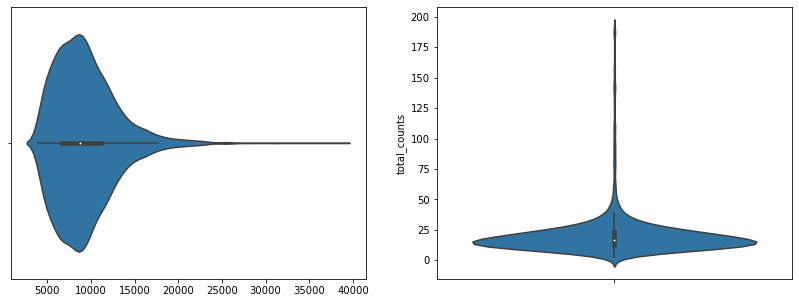

In [28]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))
sbn.violinplot(np.sum(aragona_data.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(data = df, y = 'total_counts', orient='v', ax = axes[1], hue = 'batch')

In [29]:
ife = adata_subset[adata_subset.obs['batch'] == '10x'].copy()
ivl = adata_subset[adata_subset.obs['batch'] == 'Ivl'].copy()
c1 = adata_subset[adata_subset.obs['batch'] == 'C1'].copy()

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical o

<AxesSubplot:>

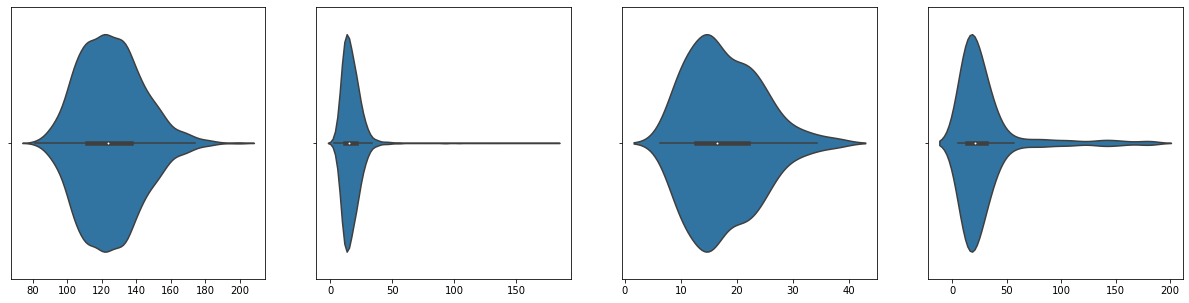

In [30]:
fig, axes = plt.subplots(ncols = 4, figsize = (21, 5))
sbn.violinplot(np.sum(aragona_ife_subset.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(np.sum(ife.X, axis = 1), orient='v', ax = axes[1])
sbn.violinplot(np.sum(ivl.X, axis = 1), orient='v', ax = axes[2])
sbn.violinplot(np.sum(c1.X, axis = 1), orient='v', ax = axes[3])

## Scale all data independently before concatenating

In [31]:
scaled_aragona = sc.pp.scale(aragona_ife_subset, copy=True)
scaled_10x = sc.pp.scale(ife, copy=True)
scaled_c1 = sc.pp.scale(c1, copy=True)
scaled_ivl = sc.pp.scale(ivl, copy=True)

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical o

Text(0.5, 1.0, 'C1')

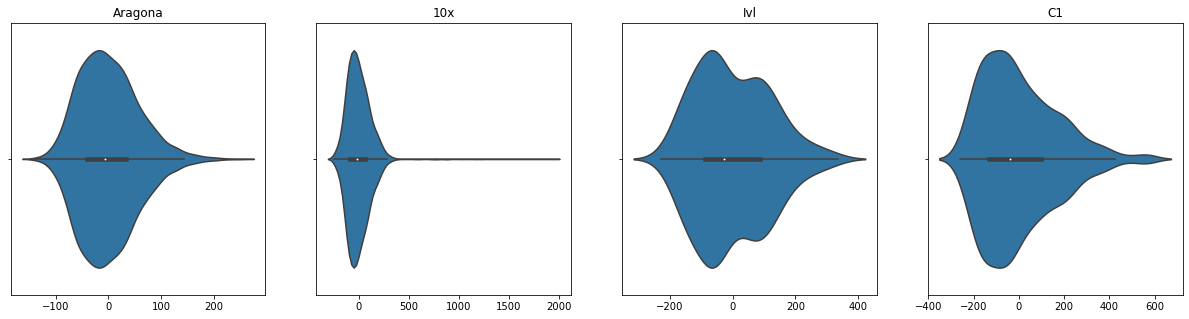

In [32]:
fig, axes = plt.subplots(ncols = 4, figsize = (21, 5), sharey = True)
sbn.violinplot(np.sum(scaled_aragona.X, axis = 1), orient='v', ax = axes[0])
sbn.violinplot(np.sum(scaled_10x.X, axis = 1), orient='v', ax = axes[1])
sbn.violinplot(np.sum(scaled_ivl.X, axis = 1), orient='v', ax = axes[2])
sbn.violinplot(np.sum(scaled_c1.X, axis = 1), orient='v', ax = axes[3])
axes[0].set_title('Aragona')
axes[1].set_title('10x')
axes[2].set_title('Ivl')
axes[3].set_title('C1')

In [33]:
scaled_ife = scaled_10x.concatenate(scaled_ivl, scaled_c1, batch_key = None)
scaled_ife.obs_names = scaled_ife.obs_names.str[:-2]

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Try bbknn

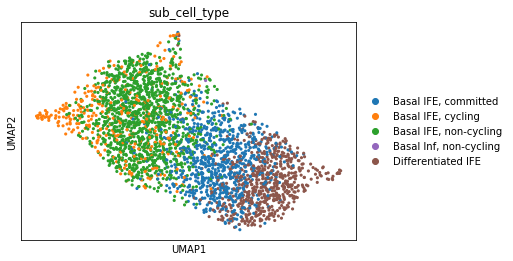

In [81]:
sc.pp.pca(scaled_aragona)
sc.pp.neighbors(scaled_aragona)
sc.tl.umap(scaled_aragona)
sc.pl.umap(scaled_aragona, color = 'sub_cell_type')

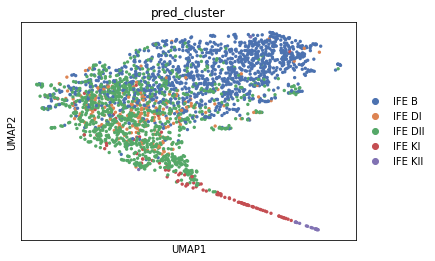

In [82]:
sc.pp.pca(scaled_ife)
sc.pp.neighbors(scaled_ife)
sc.tl.umap(scaled_ife, min_dist = 0.1)
sc.pl.umap(scaled_ife, color = 'pred_cluster')

In [83]:
bbknn_data = scaled_ife.concatenate(scaled_aragona, batch_key='dataset', batch_categories=['mka','aragona'])

/home/karl/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/merge.py:894: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


In [85]:
bbknn.bbknn(bbknn_data, batch_key = 'dataset')

/home/karl/anaconda3/envs/scanpy/lib/python3.6/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/karl/anaconda3/envs/scanpy/lib/python3.6/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [92]:
#bbknn_data.obs['bbknn_data_clusters'] = [x[x[1] != 'nan'][0] for x in bbknn_data.obs[['pred_cluster', 'sub_cell_type']].values]
bbknn_data.obs['comb_clusters'] = [x[1] if x[1] != 'nan' else x[0] for x in bbknn_data.obs[['pred_cluster', 'cell_type']].values]
#bbknn_data.obs['cell_identity'] = bbknn_data.obs['cell_identity'].fillna(value = 'Aragona')

... storing 'comb_clusters' as categorical


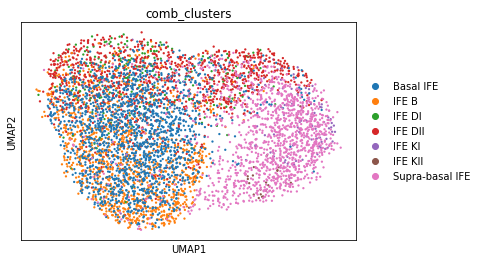

In [93]:
sc.pl.umap(bbknn_data, color = 'comb_clusters')

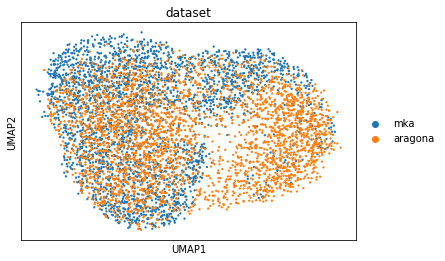

In [91]:
sc.pl.umap(bbknn_data, color = 'dataset')

# Try ingest

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


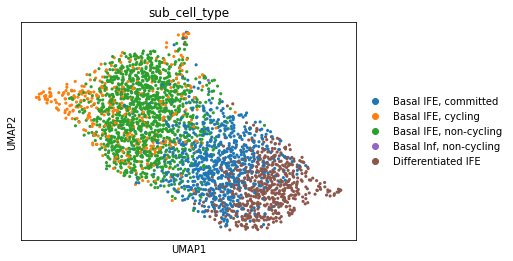

In [34]:
sc.pp.pca(scaled_aragona)
sc.pp.neighbors(scaled_aragona)
sc.tl.umap(scaled_aragona)
sc.pl.umap(scaled_aragona, color = 'sub_cell_type')

In [35]:
#Having X_diffmap in caused an error (dpt calculations maybe dind't carry over)
del scaled_ife.obsm['X_diffmap']

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing '10x_leiden' as categorical
... storing 'Basa-Suprabasal' as categorical
... storing 'C1_pred_cluster' as categorical
... storing 'Ivl_cells' as categorical
... storing 'Krt10 class' as categorical
... storing 'Krt10_class_mean' as categorical
... storing 'Krt10_group' as categorical
... storing 'Krt14_group' as categorical
... storing 'Location' as categorical
... storing 'batch' as categorical
... storing 'cell_identity' as categorical
... storing 'clustering' as categorical
... storing 'layer' as categorical
... storing 'leiden' as categorical
... storing 'leiden_named' as categorical
... storing 'phase' as categorical
... storing 'phase_c0' as categorical
... storing 'phase_c0.05' as categorical
... st

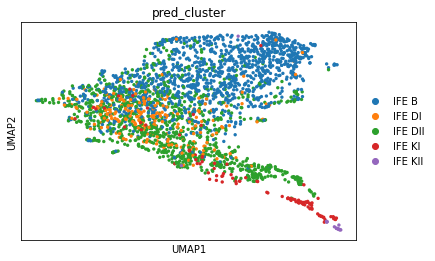

In [36]:
sc.pp.pca(scaled_ife)
sc.pp.neighbors(scaled_ife)
sc.tl.umap(scaled_ife, min_dist = 0.1)
sc.pl.umap(scaled_ife, color = 'pred_cluster')

In [37]:
scaled_ife.obsm['X_umap'] = adata.obsm['X_umap']

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
ingest_data = sc.tl.ingest(adata = scaled_aragona, adata_ref = scaled_ife, obs = 'pred_cluster', inplace = False)

/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/karl/anaconda3/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


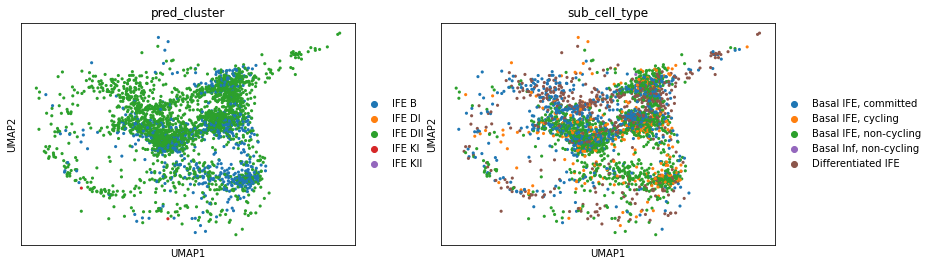

In [39]:
sc.pl.umap(ingest_data, color = ['pred_cluster', 'sub_cell_type'])

In [40]:
comb = scaled_ife.concatenate(ingest_data)

In [41]:
#comb.obs['comb_clusters'] = [x[x[1] != 'nan'][0] for x in comb.obs[['pred_cluster', 'sub_cell_type']].values]
comb.obs['comb_clusters'] = [x[1] if x[1] != 'nan' else x[0] for x in comb.obs[['pred_cluster', 'sub_cell_type']].values]
comb.obs['cell_identity'] = comb.obs['cell_identity'].fillna(value = 'Aragona')

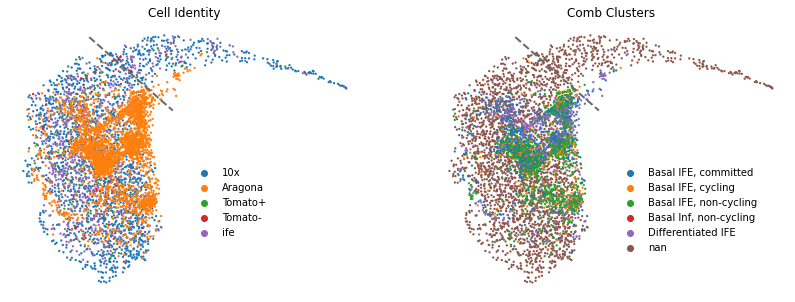

In [44]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))
for ix, col in enumerate(['comb_clusters', 'cell_identity'][::-1]):
    ax = axes[ix]
    sc.pl.umap(comb, color = col, frameon = False, ax = ax, show = False)
    plot_basal_suprabasal_cutoff_v2(ax, x1 = 1.5)
    ax.legend(bbox_to_anchor = (0.5, 0.5), frameon = False)
    ax.set_title(col.title().replace('_', ' '))
    
#fig.savefig(os.path.join(fig_path, 'Aragona_ingest_scaled_independently.png'), pad_inches = 0.1, bbox_inches = 'tight', dpi = 300)

# Checkpoint

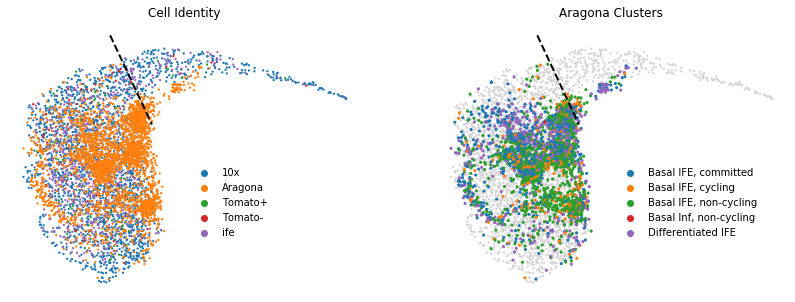

In [65]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 5))

ax = axes[0]
sc.pl.umap(comb, color = 'cell_identity', frameon = False, ax = ax, show = False)
plot_basal_suprabasal_cutoff(ax, color = 'k')
ax.legend(bbox_to_anchor = (0.5, 0.5), frameon = False)
ax.set_title('Cell Identity')

ax = axes[1]
sc.pl.umap(comb, frameon = False, ax = ax, show = False)
sc.pl.umap(comb[comb.obs['cell_identity']=='Aragona'], color = 'comb_clusters', frameon = False, ax = ax, show = False)
plot_basal_suprabasal_cutoff(ax, color = 'k')
ax.legend(bbox_to_anchor = (0.5, 0.5), frameon = False)
ax.set_title('Aragona Clusters')
    
fig.savefig(os.path.join(fig_path, 'Aragona_ingest_scaled_independently.png'), pad_inches = 0.1, bbox_inches = 'tight', dpi = 300)

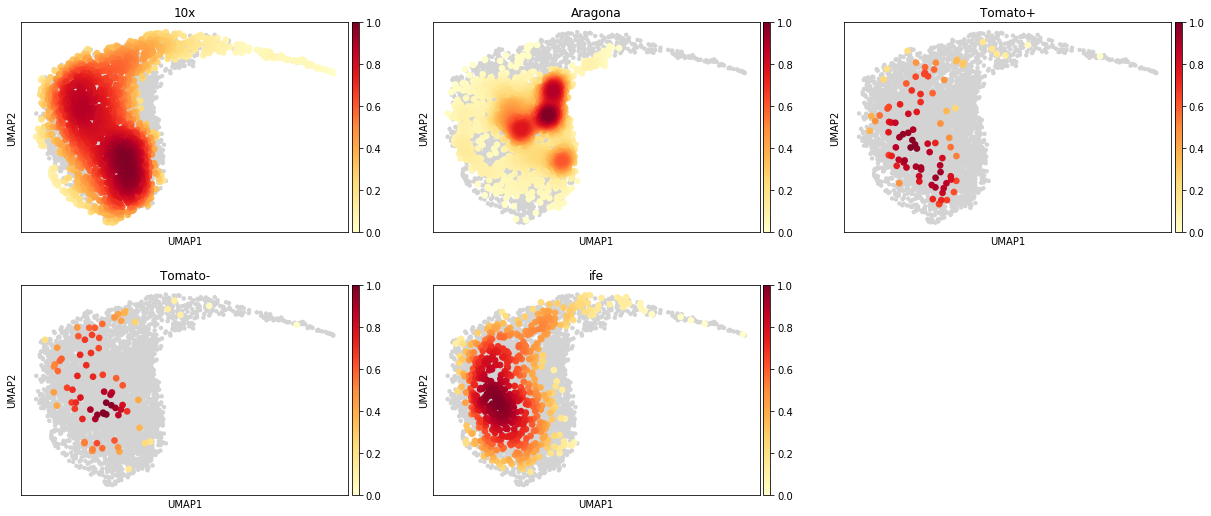

In [36]:
group = 'cell_identity'
sc.tl.embedding_density(comb, basis = 'umap', groupby = group)
sc.pl.embedding_density(comb, basis = 'umap', key = 'umap_density_{}'.format(group), ncols = 3)

In [37]:
comb.obs_names = comb.obs_names.str[:-2]

In [38]:
shared_genes = aragona_ife.var_names.intersection(raw_data.var_names)
comb_raw = aragona_data[:, shared_genes].concatenate(raw_data[:, shared_genes])

In [39]:
comb_raw.obs_names = comb_raw.obs_names.str[:-2]

In [40]:
comb.raw = comb_raw[comb.obs_names]

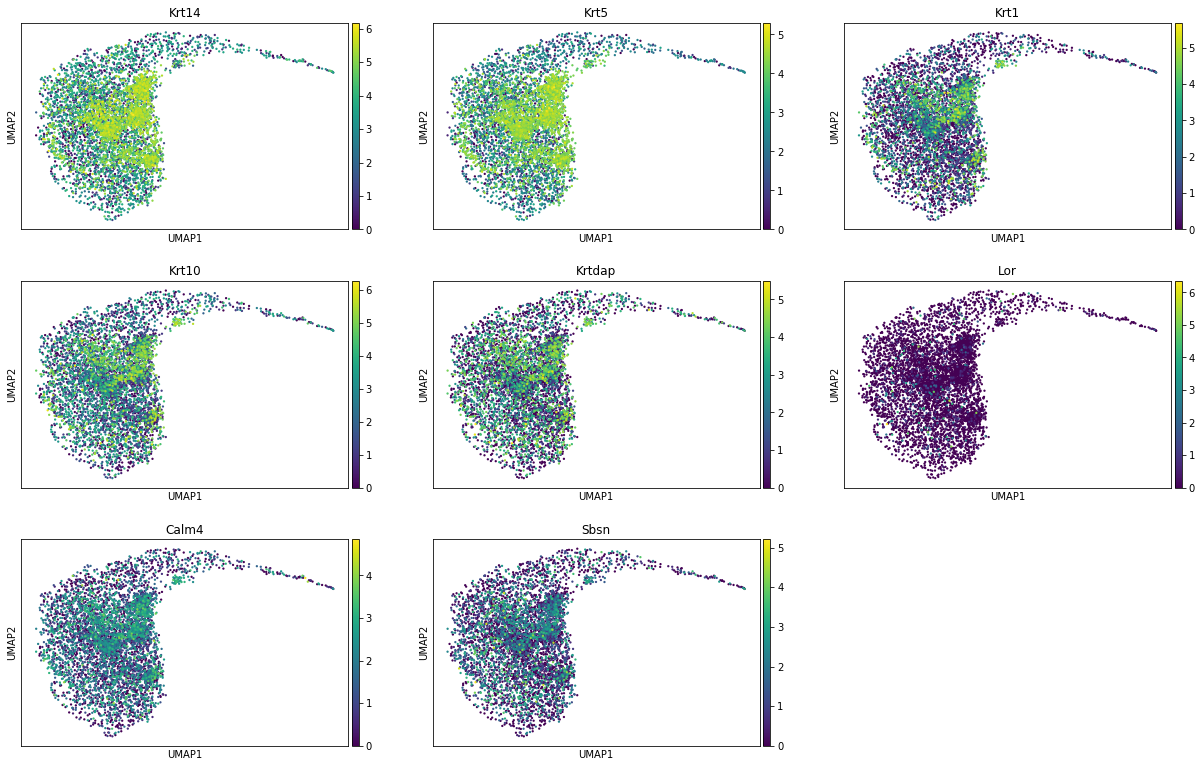

In [41]:
genes = ['Krt14','Krt5','Krt1','Krt10','Krtdap','Lor','Flg','Calm4','Sbsn']
genes = [x for x in genes if x in comb.raw.var_names]
sc.pl.umap(comb, color = genes, ncols = 3)

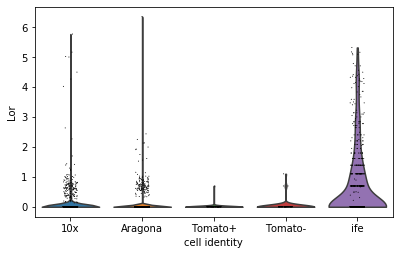

In [42]:
gene = 'Lor'
sc.pl.violin(comb, gene, groupby = 'cell_identity')

ax = axes[ix // ncols, ix % ncols]


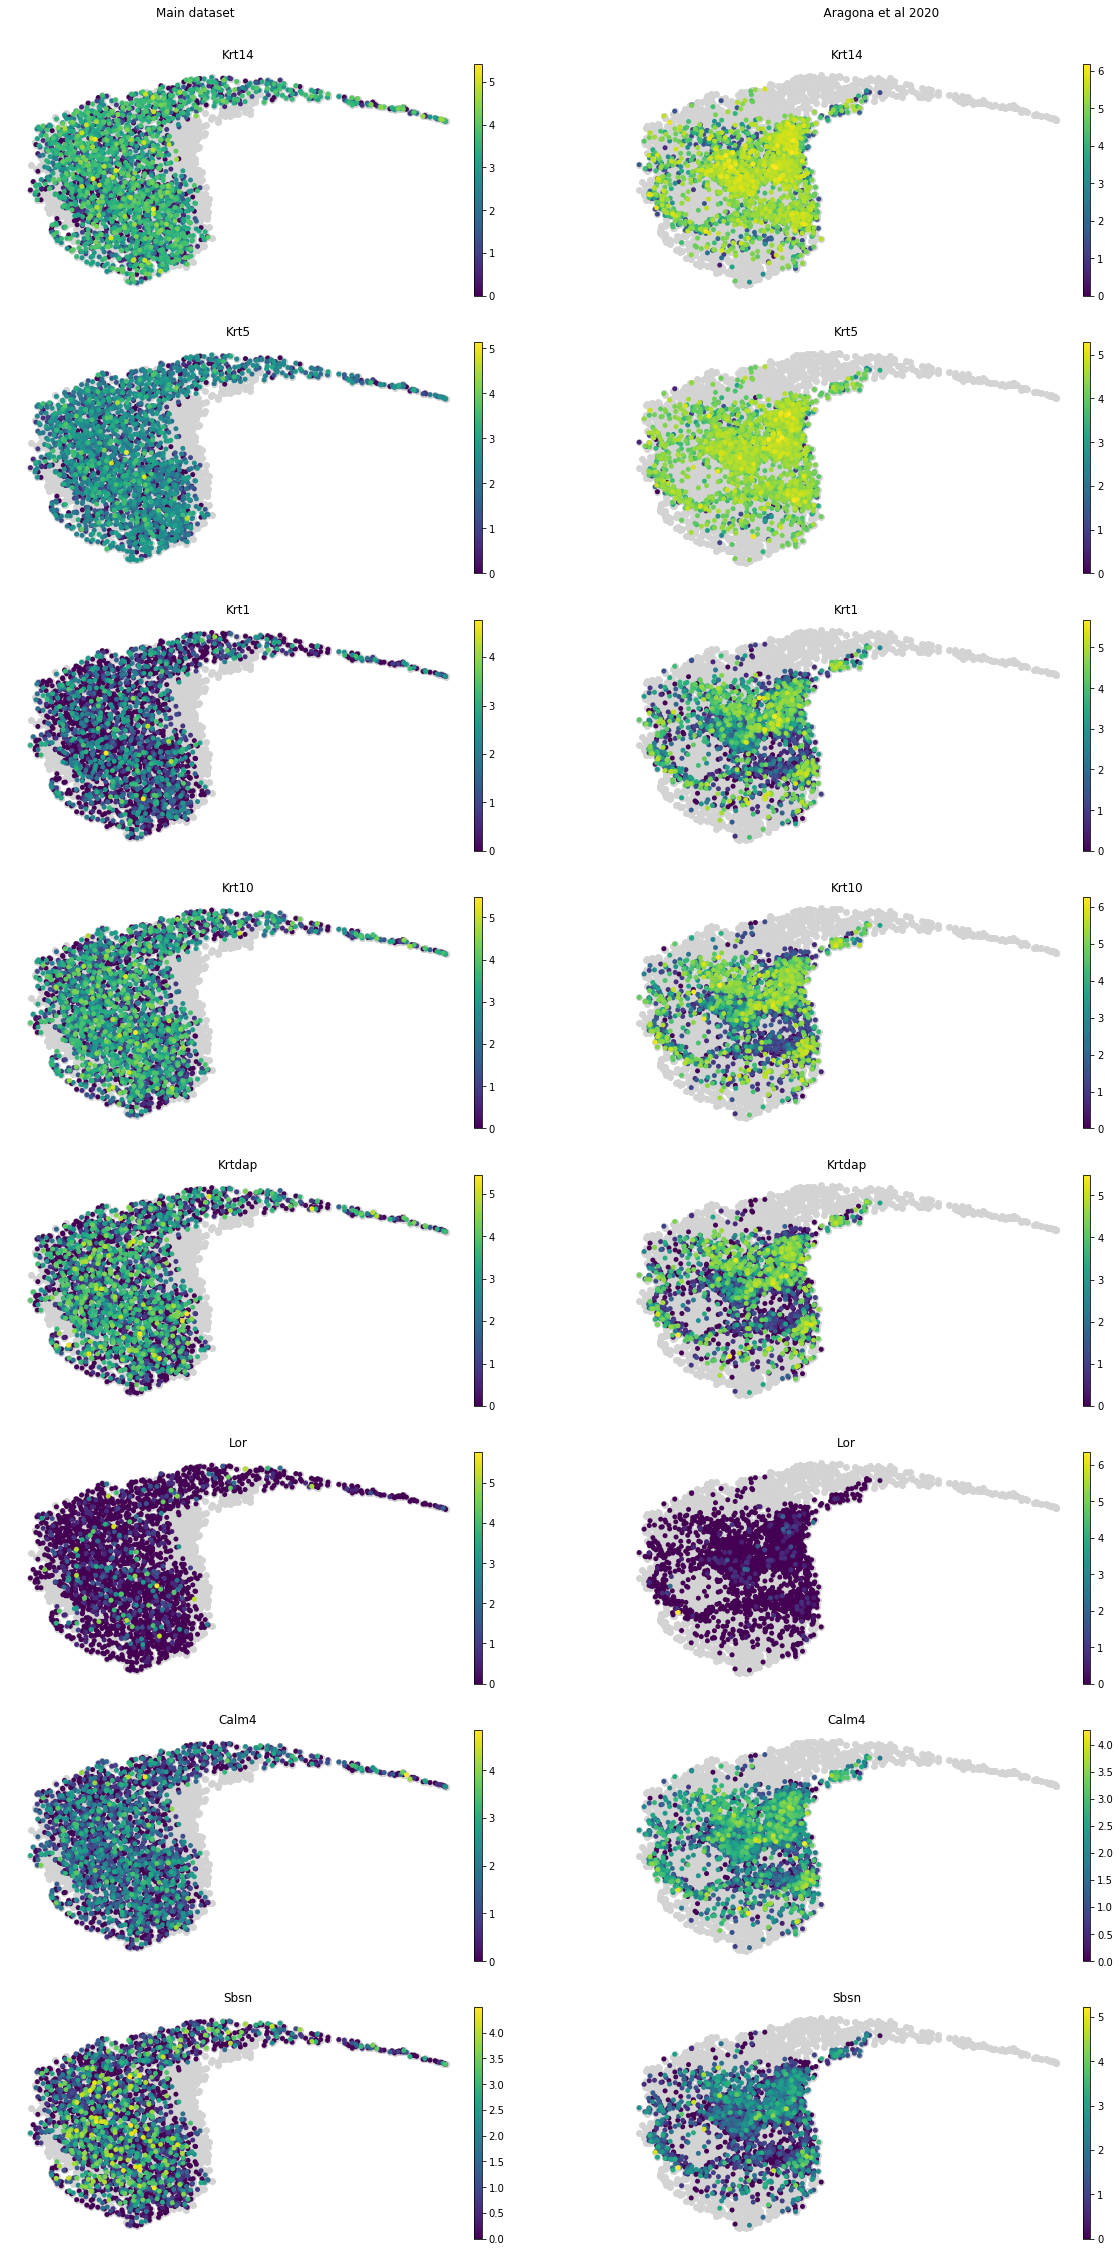

In [63]:
fig, axes = initialize_subplots(len(genes)*2, ncols = 2, figsize_multiplier=(10,5))

x, y = zip(*comb.obsm['X_umap'])

for b_ix, batch in enumerate(['0','1']):
    for g_ix, gene in enumerate(genes):
        ax = axes[g_ix, b_ix]
        tmp = comb[comb.obs['batch'] == batch].copy()
        ax.scatter(x, y, c = 'lightgrey')
        sc.pl.umap(tmp, color = gene, show = False, ax = ax, frameon = False, size = 100)
fig.suptitle('Main dataset {} Aragona et al 2020'.format(' '*150), y = 0.9)

fig.savefig(os.path.join(fig_path, 'Aragona_ingest_scaled_independently_gene_expression.png'), pad_inches = 0.1, bbox_inches = 'tight', dpi = 300)